In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from scipy.stats import boxcox
import warnings
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as stats
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
import missingno as msno
import pandas_profiling
from scipy.stats import zscore

In [2]:
pd.options.display.max_columns = 30

warnings.filterwarnings('ignore')
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

lifeexpectancy_df_Copy = lifeexpectancy_df.copy()

engine.dispose()

lifeexpectancy_df_Copy.head()

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
0             62     0.01               71.279624         65.0      1154   
1             64     0.01               73.523582         62.0       492   
2             66     0.01               73.219243         64.0       430   
3             69     0.01               78.184215         67.0      2787   
4             71     0.01                7.097109         68.0      3013   

    BMI   under-five deaths   Polio  Total expenditure  Diphtheria   \
0   19.1                  83    6.0               8.16         65.0   
1   18.6                  86   58.0               8.18         62.0   
2   18.1                  89   62.0               8.13         64.0   
3   17.6                  93   67.0               8.52         67.0   
4   17.2                  97   68.0               7.87         68.0   

    HIV/AIDS         GDP  Population   thinness  1-19 years  \
0        0.1  584.259210  33736494.0                   17.2   
1        0.1  612.696514    327582.0                   17.5   
2        0.1  631.744976  31731688.0                   17.7   
3        0.1  669.959000   3696958.0                   17.9   
4        0.1   63.537231   2978599.0                   18.2   

    thinness 5-9 years  Income composition of resources  Schooling  
0                 17.3                            0.479       10.1  
1                 17.5                            0.476       10.0  
2                 17.7                            0.470        9.9  
3                 18.0                            0.463        9.8  
4                 18.2                            0.454        9.5

In [3]:
pandas_profiling.ProfileReport(lifeexpectancy_df_Copy)

The profiling report above gives an immediate analysis of the data. Most categories have data that will need to be cleaned up. The distribution of the data will help us figure out the best method for filling Nan's and how to deal with outliers.

## Cleaning

The graph below displays the missing values within each column. This will help us determine what type of missing data we have.

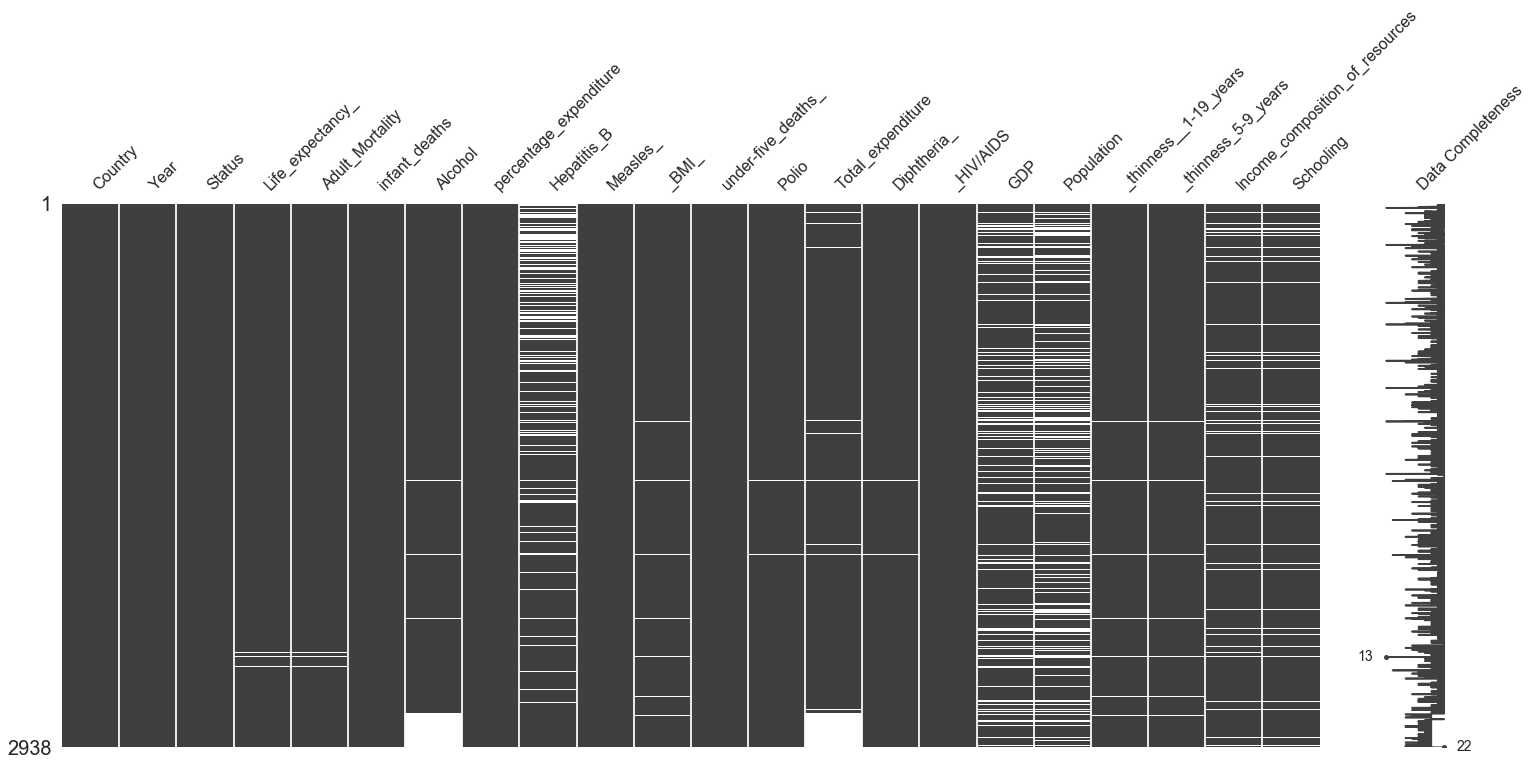

In [4]:
msno.matrix(lifeexpectancy_df_Copy.sort_values('Year'), labels=True)
plt.show()

In [7]:
lifeexpectancy_df_Copy.loc[lifeexpectancy_df_Copy.Alcohol.isnull(), 'Year'].value_counts()

2015    177
2013      2
2005      2
2014      1
2012      1
2011      1
2010      1
2009      1
2008      1
2007      1
2006      1
2004      1
2003      1
2002      1
2001      1
2000      1
Name: Year, dtype: int64

In [28]:
lifeexpectancy_df_Copy.loc[lifeexpectancy_df_Copy['Total expenditure'].isnull(), 'Year'].value_counts()

2015    181
2002      4
2001      4
2000      4
2011      3
2010      3
2009      3
2008      3
2007      3
2006      3
2005      3
2004      3
2003      3
2014      2
2013      2
2012      2
Name: Year, dtype: int64

Here we see that the alcohol and total expenditure categories are missing most of the 2015 year's data. Hepatitis B also has most of the missing values in the earlier years. Interpolating these categories will produce healthy fill values. 

In [5]:
for country in lifeexpectancy_df_Copy['Country'].unique():
    ind = None
    n = -1
    for value in lifeexpectancy_df_Copy[lifeexpectancy_df_Copy.Country == country].sort_values('Year').iloc[:,6]:
        n += 1
        if math.isnan(value) == True :
            ind = lifeexpectancy_df_Copy[lifeexpectancy_df_Copy.Country == country].sort_values('Year').iloc[:,6].interpolate().index[n]
            lifeexpectancy_df_Copy.iloc[ind, 6] = lifeexpectancy_df_Copy[lifeexpectancy_df_Copy.Country == country].sort_values('Year').iloc[:,6].interpolate(limit_direction = 'both').iloc[n]
    
for country in lifeexpectancy_df_Copy['Country'].unique():
    ind = None
    n = -1
    for value in lifeexpectancy_df_Copy[lifeexpectancy_df_Copy.Country == country].sort_values('Year').iloc[:,8]:
        n += 1
        if math.isnan(value) == True :
            ind = lifeexpectancy_df_Copy[lifeexpectancy_df_Copy.Country == country].sort_values('Year').iloc[:,8].interpolate().index[n]
            lifeexpectancy_df_Copy.iloc[ind, 8] = lifeexpectancy_df_Copy[lifeexpectancy_df_Copy.Country == country].sort_values('Year').iloc[:,8].interpolate(limit_direction = 'both').iloc[n]
            
for country in lifeexpectancy_df_Copy['Country'].unique():
    ind = None
    n = -1
    for value in lifeexpectancy_df_Copy[lifeexpectancy_df_Copy.Country == country].sort_values('Year').iloc[:,13]:
        n += 1
        if math.isnan(value) == True :
            ind = lifeexpectancy_df_Copy[lifeexpectancy_df_Copy.Country == country].sort_values('Year').iloc[:,13].interpolate().index[n]
            lifeexpectancy_df_Copy.iloc[ind, 13] = lifeexpectancy_df_Copy[lifeexpectancy_df_Copy.Country == country].sort_values('Year').iloc[:,13].interpolate(limit_direction = 'both').iloc[n]

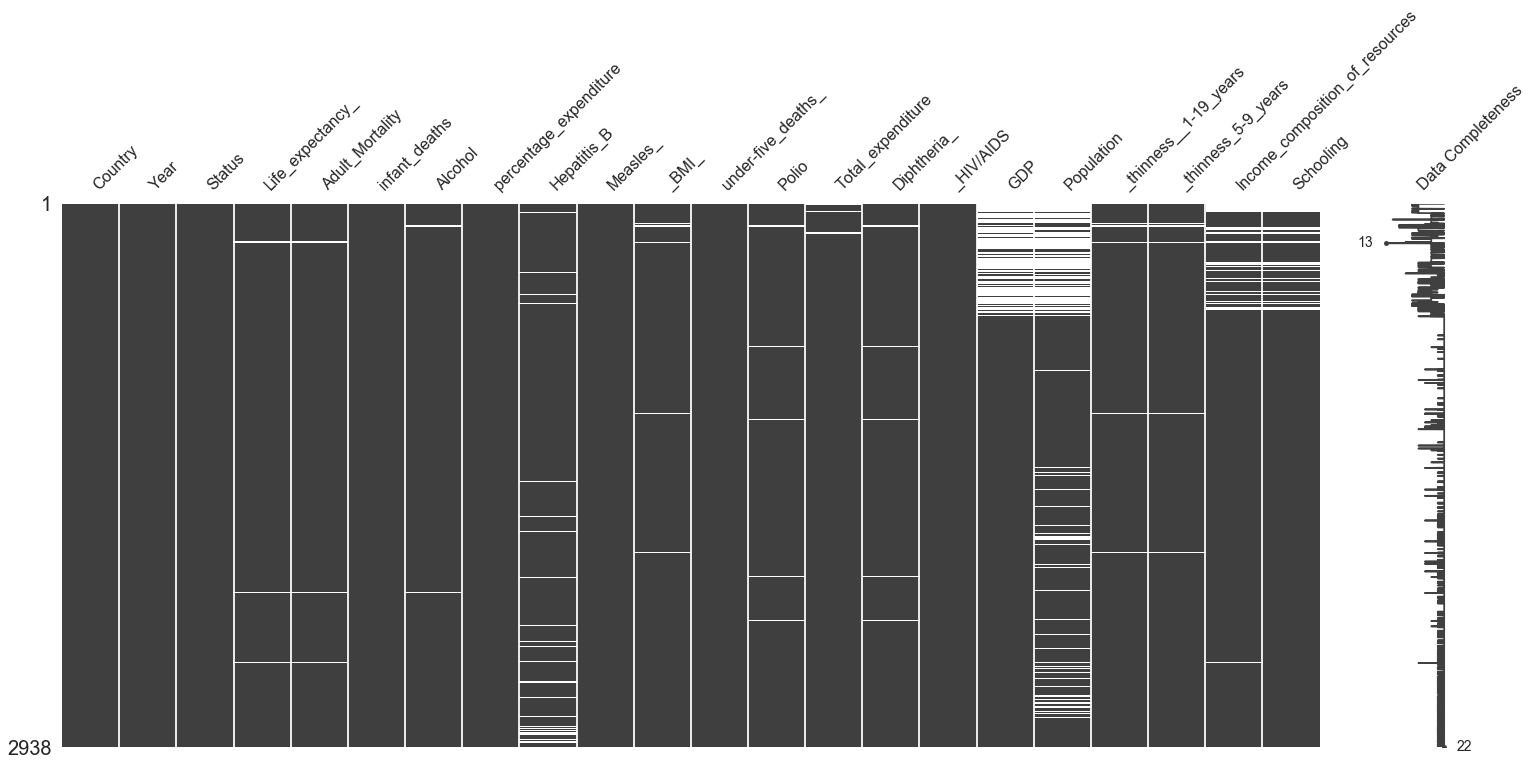

In [6]:
msno.matrix(lifeexpectancy_df_Copy.sort_values('percentage_expenditure'), labels=True)
plt.show()

From here, it is clear that many of the rows missing values in GDP are also missing values in population. The same behavior is seen between income composition of resources and schooling. It seems that the countries with a lower percentage expenditure are more likely to have missing GDP, population, income composition of resources, and schooling. This shows that the data is missing not at random.

In [39]:
lifeexpectancy_df_Copy.corr().iloc[[14,15,18,19],:]

Year  Life_expectancy_  Adult_Mortality  \
GDP                              0.101620          0.461455        -0.296049   
Population                       0.016969         -0.021538        -0.013647   
Income_composition_of_resources  0.243468          0.724776        -0.457626   
Schooling                        0.209400          0.751975        -0.454612   

                                 infant_deaths   Alcohol  \
GDP                                  -0.108427  0.351018   
Population                            0.556801 -0.034677   
Income_composition_of_resources      -0.145139  0.446115   
Schooling                            -0.193720  0.540050   

                                 percentage_expenditure  Hepatitis_B  \
GDP                                            0.899373     0.064010   
Population                                    -0.025662    -0.086753   
Income_composition_of_resources                0.381952     0.276944   
Schooling                                      0.389687     0.302510   

                                 Measles_     _BMI_  under-five_deaths_  \
GDP                             -0.076466  0.301557           -0.112081   
Population                       0.265966 -0.072301            0.544423   
Income_composition_of_resources -0.129568  0.508774           -0.163305   
Schooling                       -0.137225  0.546961           -0.209373   

                                    Polio  Total_expenditure  Diphtheria_  \
GDP                              0.211976           0.133464     0.200666   
Population                      -0.038540          -0.077830    -0.028444   
Income_composition_of_resources  0.381078           0.183766     0.401456   
Schooling                        0.417866           0.262539     0.425332   

                                 _HIV/AIDS       GDP  Population  \
GDP                              -0.136491  1.000000   -0.028270   
Population                       -0.027854 -0.028270    1.000000   
Income_composition_of_resources  -0.249519  0.460341   -0.008735   
Schooling                        -0.220429  0.448273   -0.031668   

                                 _thinness__1-19_years  _thinness_5-9_years  \
GDP                                          -0.285697            -0.290539   
Population                                    0.253944             0.251403   
Income_composition_of_resources              -0.422429            -0.411053   
Schooling                                    -0.471652            -0.460632   

                                 Income_composition_of_resources  Schooling  
GDP                                                     0.460341   0.448273  
Population                                             -0.008735  -0.031668  
Income_composition_of_resources                         1.000000   0.800092  
Schooling                                               0.800092   1.000000

Since GDP is highly correlated with percentage expenditure (90%), sorting the rows by their percentage expenditure and then interpolating should give reasonable fill values. Population, income composition of resources, and schooling are not highly correlated with other categories. Thus, these categories, along with others, will be filled based on their distributions. Normal distributed categories will be filled with their countries mean values while skewed data will be filled with their countries median values.

In [7]:
ind = None
n = -1
for value in lifeexpectancy_df_Copy.sort_values('percentage_expenditure').iloc[:,16]:
    n += 1
    if math.isnan(value) == True :
        ind = lifeexpectancy_df_Copy.sort_values('percentage_expenditure').iloc[:,16].interpolate().index[n]
        lifeexpectancy_df_Copy.iloc[ind, 16] = lifeexpectancy_df_Copy.sort_values('percentage_expenditure').iloc[:,16].interpolate(limit_direction = 'both').iloc[n]

In [8]:
n = -1
for value in lifeexpectancy_df_Copy.iloc[:,10]:
    n+=1
    lifeexpectancy_df_Copy.iloc[n,10] = abs(value - lifeexpectancy_df_Copy.iloc[:,10].mean())
    
lifeexpectancy_df_Copy.iloc[:,10] = lifeexpectancy_df_Copy.iloc[:,10].fillna(lifeexpectancy_df_Copy.iloc[:,10].mean())

In [12]:
for country in lifeexpectancy_df_Copy['Country'].unique():
    lifeexpectancy_df_Copy.iloc[:,3] = lifeexpectancy_df_Copy.iloc[:,3].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,3].mean())
    lifeexpectancy_df_Copy.iloc[:,4] = lifeexpectancy_df_Copy.iloc[:,4].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,4].median())
    lifeexpectancy_df_Copy.iloc[:,6] = lifeexpectancy_df_Copy.iloc[:,6].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,6].median())
    lifeexpectancy_df_Copy.iloc[:,8] = lifeexpectancy_df_Copy.iloc[:,8].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,8].median())
    lifeexpectancy_df_Copy.iloc[:,12] = lifeexpectancy_df_Copy.iloc[:,12].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,12].median())
    lifeexpectancy_df_Copy.iloc[:,13] = lifeexpectancy_df_Copy.iloc[:,13].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,13].mean())
    lifeexpectancy_df_Copy.iloc[:,14] = lifeexpectancy_df_Copy.iloc[:,14].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,14].median())
    lifeexpectancy_df_Copy.iloc[:,17] = lifeexpectancy_df_Copy.iloc[:,17].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,17].median())
    lifeexpectancy_df_Copy.iloc[:,18] = lifeexpectancy_df_Copy.iloc[:,18].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,18].median())
    lifeexpectancy_df_Copy.iloc[:,19] = lifeexpectancy_df_Copy.iloc[:,19].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,19].median())
    lifeexpectancy_df_Copy.iloc[:,20] = lifeexpectancy_df_Copy.iloc[:,20].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,20].mean())
    lifeexpectancy_df_Copy.iloc[:,21] = lifeexpectancy_df_Copy.iloc[:,21].fillna(lifeexpectancy_df_Copy[lifeexpectancy_df_Copy['Country'] == country ].iloc[:,21].mean())
        

In [15]:
lifeexpectancy_df_Copy = lifeexpectancy_df_Copy.reset_index(drop = True)
lifeexpectancy_df_Copy.describe()

Year  Life_expectancy_  Adult_Mortality  infant_deaths  \
count  2938.000000       2938.000000      2938.000000    2938.000000   
mean   2007.518720         69.187385       165.202178      30.303948   
std       4.613841          9.529330       124.274444     117.926501   
min    2000.000000         36.300000         1.000000       0.000000   
25%    2004.000000         63.000000        74.000000       0.000000   
50%    2008.000000         72.000000       144.000000       3.000000   
75%    2012.000000         75.600000       228.000000      22.000000   
max    2015.000000         89.000000       723.000000    1800.000000   

           Alcohol  percentage_expenditure  Hepatitis_B       Measles_  \
count  2938.000000             2938.000000  2938.000000    2938.000000   
mean      4.491710              738.251295    75.237236    2419.592240   
std       4.073512             1987.914858    28.024198   11467.272489   
min       0.010000                0.000000     1.000000       0.000000   
25%       0.600000                4.685343    64.000000       0.000000   
50%       3.565000               64.912906    88.000000      17.000000   
75%       7.600000              441.534144    96.000000     360.250000   
max      17.870000            19479.911610    99.000000  212183.000000   

             _BMI_  under-five_deaths_        Polio  Total_expenditure  \
count  2938.000000         2938.000000  2938.000000        2938.000000   
mean     19.863150           42.035739    82.391423           5.964292   
std      11.372645          160.445548    23.434940           2.515196   
min       0.008379            0.000000     3.000000           0.370000   
25%      10.675621            0.000000    77.000000           4.270000   
50%      19.839336            4.000000    93.000000           5.780000   
75%      28.180440           28.000000    97.000000           7.567500   
max      60.969691         2500.000000    99.000000          17.600000   

       Diphtheria_    _HIV/AIDS            GDP    Population  \
count  2938.000000  2938.000000    2938.000000  2.938000e+03   
mean     82.195882     1.742103    7396.242207  1.057222e+07   
std      23.693437     5.077785   13537.075836  5.397027e+07   
min       2.000000     0.100000       1.681350  3.400000e+01   
25%      78.000000     0.100000     565.805563  4.189172e+05   
50%      93.000000     0.100000    2276.444865  2.924815e+06   
75%      97.000000     0.800000    6489.116643  4.584371e+06   
max      99.000000    50.600000  119172.741800  1.293859e+09   

       _thinness__1-19_years  _thinness_5-9_years  \
count            2938.000000          2938.000000   
mean                4.997788             5.025732   
std                 4.631107             4.707270   
min                 0.100000             0.100000   
25%                 1.600000             1.600000   
50%                 3.400000             3.400000   
75%                 7.300000             7.300000   
max                27.700000            28.600000   

       Income_composition_of_resources    Schooling  
count                      2938.000000  2938.000000  
mean                          0.615491    11.783062  
std                           0.210631     3.377173  
min                           0.000000     0.000000  
25%                           0.465000     9.500000  
50%                           0.662000    12.100000  
75%                           0.772000    14.100000  
max                           0.948000    20.700000

We have now cleaned all the data appropriately without having to drop any data. We now move on to dealing with outliers.

## Outliers

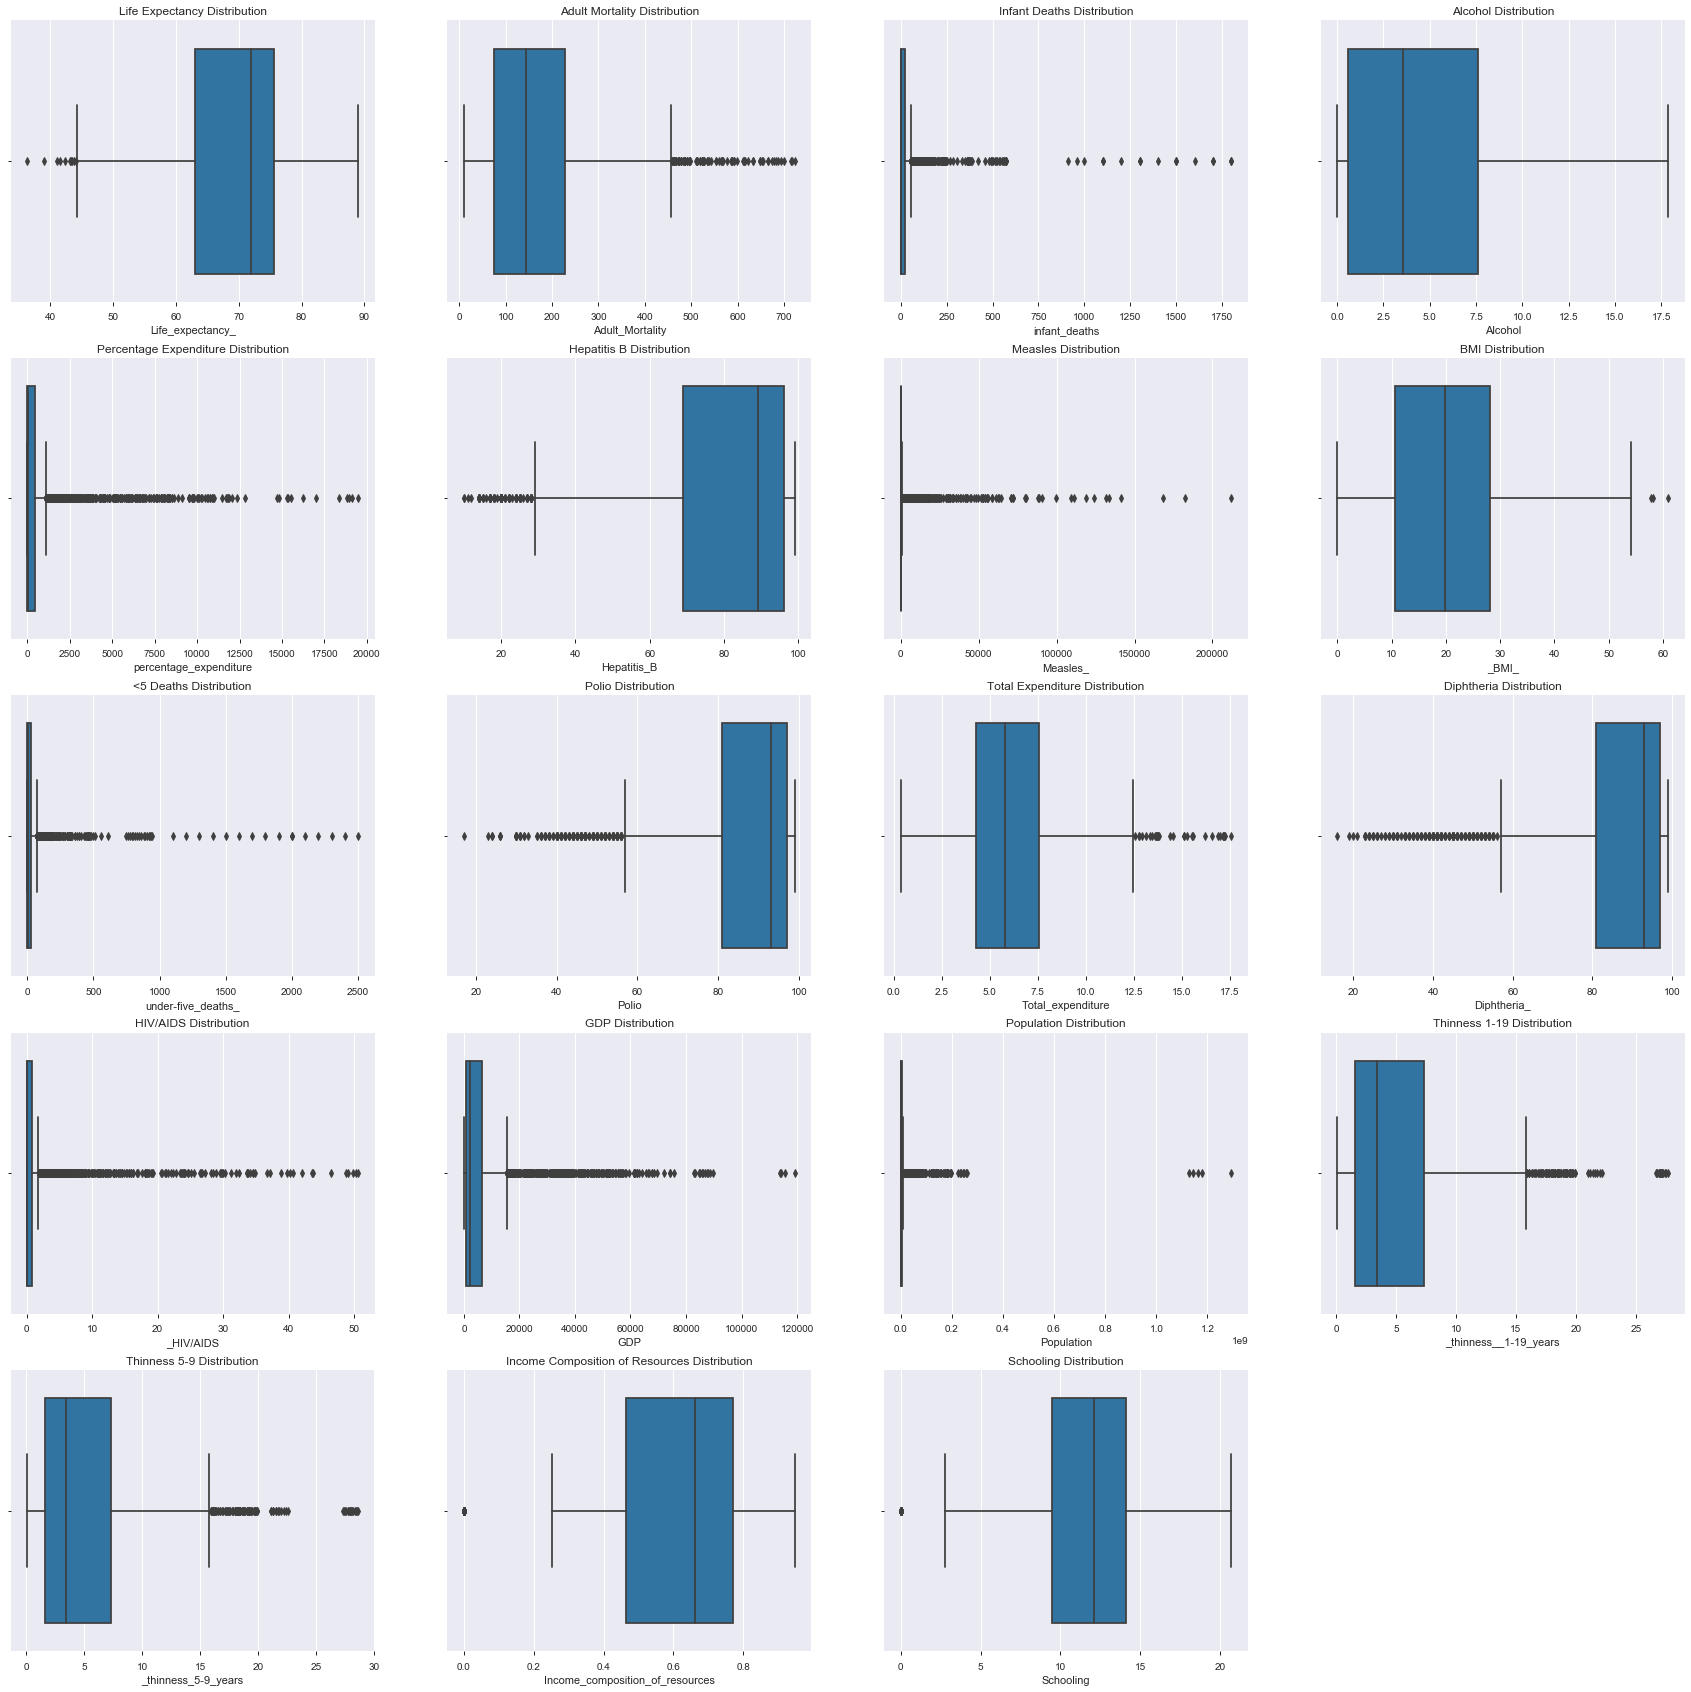

In [39]:
plt.figure(figsize = (30,30))

plt.subplot(5,4,1)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,3])
plt.title('Life Expectancy Distribution')
plt.subplot(5,4,2)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,4])
plt.title('Adult Mortality Distribution')
plt.subplot(5,4,3)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,5])
plt.title('Infant Deaths Distribution')
plt.subplot(5,4,4)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,6])
plt.title('Alcohol Distribution')
plt.subplot(5,4,5)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,7])
plt.title('Percentage Expenditure Distribution')
plt.subplot(5,4,6)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,8])
plt.title('Hepatitis B Distribution')
plt.subplot(5,4,7)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,9])
plt.title('Measles Distribution')
plt.subplot(5,4,8)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,10])
plt.title('BMI Distribution')
plt.subplot(5,4,9)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,11])
plt.title('<5 Deaths Distribution')
plt.subplot(5,4,10)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,12])
plt.title('Polio Distribution')
plt.subplot(5,4,11)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,13])
plt.title('Total Expenditure Distribution')
plt.subplot(5,4,12)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,14])
plt.title('Diphtheria Distribution')
plt.subplot(5,4,13)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,15])
plt.title('HIV/AIDS Distribution')
plt.subplot(5,4,14)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,16])
plt.title('GDP Distribution')
plt.subplot(5,4,15)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,17])
plt.title('Population Distribution')
plt.subplot(5,4,16)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,18])
plt.title('Thinness 1-19 Distribution')
plt.subplot(5,4,17)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,19])
plt.title('Thinness 5-9 Distribution')
plt.subplot(5,4,18)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,20])
plt.title('Income Composition of Resources Distribution')
plt.subplot(5,4,19)
sns.boxplot(lifeexpectancy_df_Copy.iloc[:,21])
plt.title('Schooling Distribution')

plt.show()

Many of the variables have a significant amount of outliers and are skewed in some way. A handful of them have nonsensical values such as extremely low/high values or 0's in categories that should not have 0's in them(as shown above). Obvious errors will be corrected. Many of the variables can be transformed to reduce the number of outliers and create a more normal distribution.

In [28]:
num_list = [4,8,12,14]
for num in num_list:
    for row in lifeexpectancy_df_Copy.index:
        if lifeexpectancy_df_Copy.iloc[row,num] == 9:
            lifeexpectancy_df_Copy.iloc[row,num] = 90
        if lifeexpectancy_df_Copy.iloc[row,num] == 8:
            lifeexpectancy_df_Copy.iloc[row,num] = 80
        if lifeexpectancy_df_Copy.iloc[row,num] == 7:
            lifeexpectancy_df_Copy.iloc[row,num] = 70
        if lifeexpectancy_df_Copy.iloc[row,num] == 6:
            lifeexpectancy_df_Copy.iloc[row,num] = 60
        if lifeexpectancy_df_Copy.iloc[row,num] == 5:
            lifeexpectancy_df_Copy.iloc[row,num] = 50
        if lifeexpectancy_df_Copy.iloc[row,num] == 4:
            lifeexpectancy_df_Copy.iloc[row,num] = 40
        if lifeexpectancy_df_Copy.iloc[row,num] == 3:
            lifeexpectancy_df_Copy.iloc[row,num] = 30
        if lifeexpectancy_df_Copy.iloc[row,num] == 2:
            lifeexpectancy_df_Copy.iloc[row,num] = 20
        if lifeexpectancy_df_Copy.iloc[row,num] == 1:
            lifeexpectancy_df_Copy.iloc[row,num] = 10

For these values, when an multiple of ten is reached, one of the zeros are dropped making it a single digit. This is fixed with the code above. 

In [35]:
lifeexpectancy_df_prep = lifeexpectancy_df_Copy.copy()

lifeexpectancy_df_prep['Life_expectancy_'] = boxcox(lifeexpectancy_df_prep['Life_expectancy_'])[0]
lifeexpectancy_df_prep['Adult_Mortality'] = boxcox(lifeexpectancy_df_prep['Adult_Mortality'])[0]
lifeexpectancy_df_prep.loc[:, 'infant_deaths'] +=1
lifeexpectancy_df_prep['infant_deaths'] = boxcox(lifeexpectancy_df_prep['infant_deaths'])[0]
lifeexpectancy_df_prep['Alcohol'] = boxcox(lifeexpectancy_df_prep['Alcohol'])[0]
lifeexpectancy_df_prep.loc[:, 'percentage_expenditure'] +=1
lifeexpectancy_df_prep['percentage_expenditure'] = boxcox(lifeexpectancy_df_prep['percentage_expenditure'])[0]
lifeexpectancy_df_prep['Hepatitis_B'] = boxcox(lifeexpectancy_df_prep['Hepatitis_B'])[0]
lifeexpectancy_df_prep.loc[:, 'Measles_'] +=1
lifeexpectancy_df_prep['Measles_']  = boxcox(lifeexpectancy_df_prep['Measles_'])[0]
lifeexpectancy_df_prep['_BMI_'] = boxcox(lifeexpectancy_df_prep['_BMI_'])[0]
lifeexpectancy_df_prep.loc[:, 'under-five_deaths_'] +=1
lifeexpectancy_df_prep['under-five_deaths_'] = boxcox(lifeexpectancy_df_prep['under-five_deaths_'])[0]
lifeexpectancy_df_prep['Polio'] = boxcox(lifeexpectancy_df_prep['Polio'])[0]
lifeexpectancy_df_prep['Total_expenditure'] = boxcox(lifeexpectancy_df_prep['Total_expenditure'])[0]
lifeexpectancy_df_prep['Diphtheria_'] = boxcox(lifeexpectancy_df_prep['Diphtheria_'])[0]
lifeexpectancy_df_prep['_HIV/AIDS'] = boxcox(lifeexpectancy_df_prep['_HIV/AIDS'])[0]
lifeexpectancy_df_prep['GDP'] = boxcox(lifeexpectancy_df_prep['GDP'])[0]
lifeexpectancy_df_prep['Population'] = boxcox(lifeexpectancy_df_prep['Population'])[0]
lifeexpectancy_df_prep['_thinness__1-19_years'] = boxcox(lifeexpectancy_df_prep['_thinness__1-19_years'])[0]
lifeexpectancy_df_prep['_thinness_5-9_years'] = boxcox(lifeexpectancy_df_prep['_thinness_5-9_years'])[0]
lifeexpectancy_df_prep.loc[:, 'Income_composition_of_resources'] +=1
lifeexpectancy_df_prep['Income_composition_of_resources'] = boxcox(lifeexpectancy_df_prep['Income_composition_of_resources'])[0]
lifeexpectancy_df_prep.loc[:, 'Schooling'] +=1
lifeexpectancy_df_prep['Schooling'] = boxcox(lifeexpectancy_df_prep['Schooling'])[0]

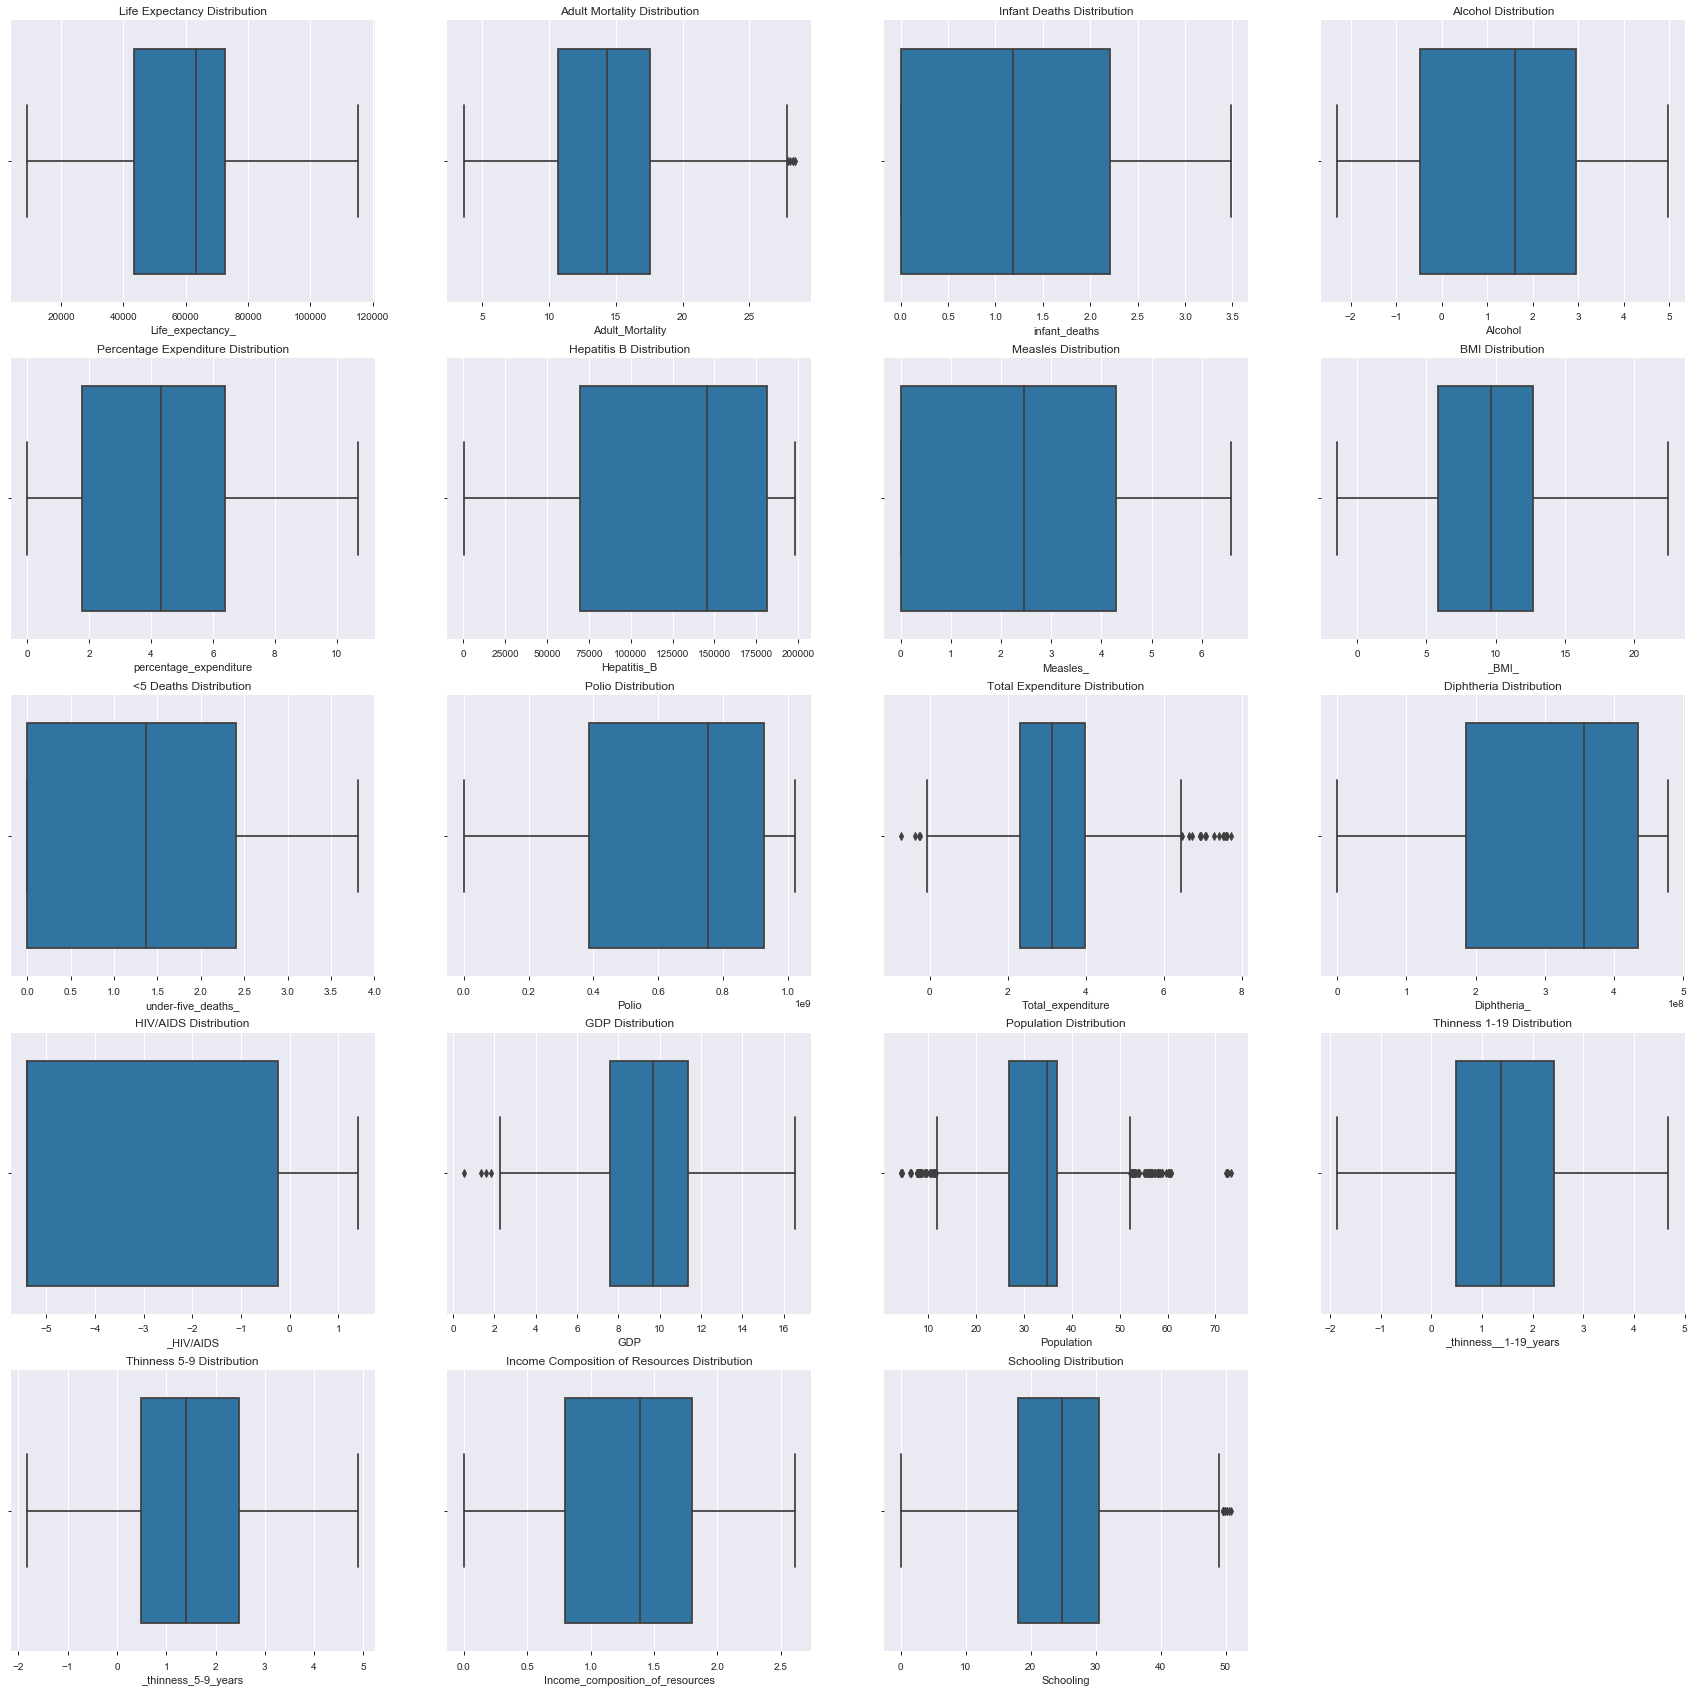

In [40]:
plt.figure(figsize = (30,30))

plt.subplot(5,4,1)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,3])
plt.title('Life Expectancy Distribution')
plt.subplot(5,4,2)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,4])
plt.title('Adult Mortality Distribution')
plt.subplot(5,4,3)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,5])
plt.title('Infant Deaths Distribution')
plt.subplot(5,4,4)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,6])
plt.title('Alcohol Distribution')
plt.subplot(5,4,5)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,7])
plt.title('Percentage Expenditure Distribution')
plt.subplot(5,4,6)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,8])
plt.title('Hepatitis B Distribution')
plt.subplot(5,4,7)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,9])
plt.title('Measles Distribution')
plt.subplot(5,4,8)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,10])
plt.title('BMI Distribution')
plt.subplot(5,4,9)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,11])
plt.title('<5 Deaths Distribution')
plt.subplot(5,4,10)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,12])
plt.title('Polio Distribution')
plt.subplot(5,4,11)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,13])
plt.title('Total Expenditure Distribution')
plt.subplot(5,4,12)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,14])
plt.title('Diphtheria Distribution')
plt.subplot(5,4,13)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,15])
plt.title('HIV/AIDS Distribution')
plt.subplot(5,4,14)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,16])
plt.title('GDP Distribution')
plt.subplot(5,4,15)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,17])
plt.title('Population Distribution')
plt.subplot(5,4,16)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,18])
plt.title('Thinness 1-19 Distribution')
plt.subplot(5,4,17)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,19])
plt.title('Thinness 5-9 Distribution')
plt.subplot(5,4,18)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,20])
plt.title('Income Composition of Resources Distribution')
plt.subplot(5,4,19)
sns.boxplot(lifeexpectancy_df_prep.iloc[:,21])
plt.title('Schooling Distribution')

plt.show()

Using the BoxCox transformation, the number of outliers were significantly reduced. Also, many of the distributions are now more normal than before. This is necessary for many models.

## Data Exploration

In [41]:
lifeexpectancy_df_prep.describe(include = 'all')

Country         Year      Status  Life_expectancy_  Adult_Mortality  \
count     2938  2938.000000        2938       2938.000000      2938.000000   
unique     193          NaN           2               NaN              NaN   
top     Canada          NaN  Developing               NaN              NaN   
freq        16          NaN        2426               NaN              NaN   
mean       NaN  2007.518720         NaN      59276.272098        14.089322   
std        NaN     4.613841         NaN      20818.388648         5.127380   
min        NaN  2000.000000         NaN       9126.785299         3.640976   
25%        NaN  2004.000000         NaN      43402.829334        10.714603   
50%        NaN  2008.000000         NaN      63319.400907        14.371392   
75%        NaN  2012.000000         NaN      72688.623725        17.549042   
max        NaN  2015.000000         NaN     115319.457456        28.389334   

        infant_deaths      Alcohol  percentage_expenditure    Hepatitis_B  \
count     2938.000000  2938.000000             2938.000000    2938.000000   
unique            NaN          NaN                     NaN            NaN   
top               NaN          NaN                     NaN            NaN   
freq              NaN          NaN                     NaN            NaN   
mean         1.239854     1.204562                4.176988  125542.213876   
std          1.021560     2.063448                2.904716   61936.628106   
min          0.000000    -2.290646                0.000000     265.539010   
25%          0.000000    -0.467871                1.761948   69922.200476   
50%          1.180292     1.599988                4.329927  145715.591101   
75%          2.207470     2.950343                6.395183  181285.219932   
max          3.489762     4.972678               10.689031  198113.920146   

           Measles_        _BMI_  under-five_deaths_         Polio  \
count   2938.000000  2938.000000         2938.000000  2.938000e+03   
unique          NaN          NaN                 NaN           NaN   
top             NaN          NaN                 NaN           NaN   
freq            NaN          NaN                 NaN           NaN   
mean       2.393073     9.218773            1.378783  6.450782e+08   
std        2.111953     4.591250            1.113139  3.236120e+08   
min        0.000000    -1.417954            0.000000  1.957821e+05   
25%        0.000000     5.867363            0.000000  3.855626e+08   
50%        2.461019     9.699415            1.363013  7.544009e+08   
75%        4.284833    12.699771            2.404817  9.256792e+08   
max        6.591717    22.438598            3.812747  1.022174e+09   

        Total_expenditure   Diphtheria_    _HIV/AIDS          GDP  \
count         2938.000000  2.938000e+03  2938.000000  2938.000000   
unique                NaN           NaN          NaN          NaN   
top                   NaN           NaN          NaN          NaN   
freq                  NaN           NaN          NaN          NaN   
mean             3.112442  3.032571e+08    -3.324507     9.613385   
std              1.264520  1.493878e+08     2.695812     2.743886   
min             -0.746628  9.352303e+04    -5.387825     0.527271   
25%              2.327997  1.866711e+08    -5.387825     7.616495   
50%              3.129707  3.566030e+08    -5.387825     9.685561   
75%              3.978130  4.343835e+08    -0.240332    11.352934   
max              7.739872  4.779707e+08     1.406382    16.536657   

         Population  _thinness__1-19_years  _thinness_5-9_years  \
count   2938.000000            2938.000000          2938.000000   
unique          NaN                    NaN                  NaN   
top             NaN                    NaN                  NaN   
freq            NaN                    NaN                  NaN   
mean      32.664061               1.421395             1.442038   
std        9.524783               1.284347             1.337830   
min   

In [45]:
for columns in column_list:
    print('The variance in {} is {}'.format(columns,lifeexpectancy_df_prep[columns].var()))

The variance in Life_expectancy_ is 433405305.8847952
The variance in Adult_Mortality is 26.29002561816043
The variance in infant_deaths is 1.0435856143400035
The variance in Alcohol is 4.257816828778724
The variance in percentage_expenditure is 8.43737623751711
The variance in Hepatitis_B is 3836145901.168459
The variance in Measles_ is 4.460344240771848
The variance in _BMI_ is 21.07957920162005
The variance in under-five_deaths_ is 1.2390777546722425
The variance in Polio is 1.0472475476063482e+17
The variance in Total_expenditure is 1.599011034875208
The variance in Diphtheria_ is 2.2316716919229172e+16
The variance in _HIV/AIDS is 7.267401990169434
The variance in GDP is 7.528909353055213
The variance in Population is 90.72149005761439
The variance in _thinness__1-19_years is 1.6495479851245582
The variance in _thinness_5-9_years is 1.7897878970153278
The variance in Income_composition_of_resources is 0.3844803349326282
The variance in Schooling is 77.28162223451203


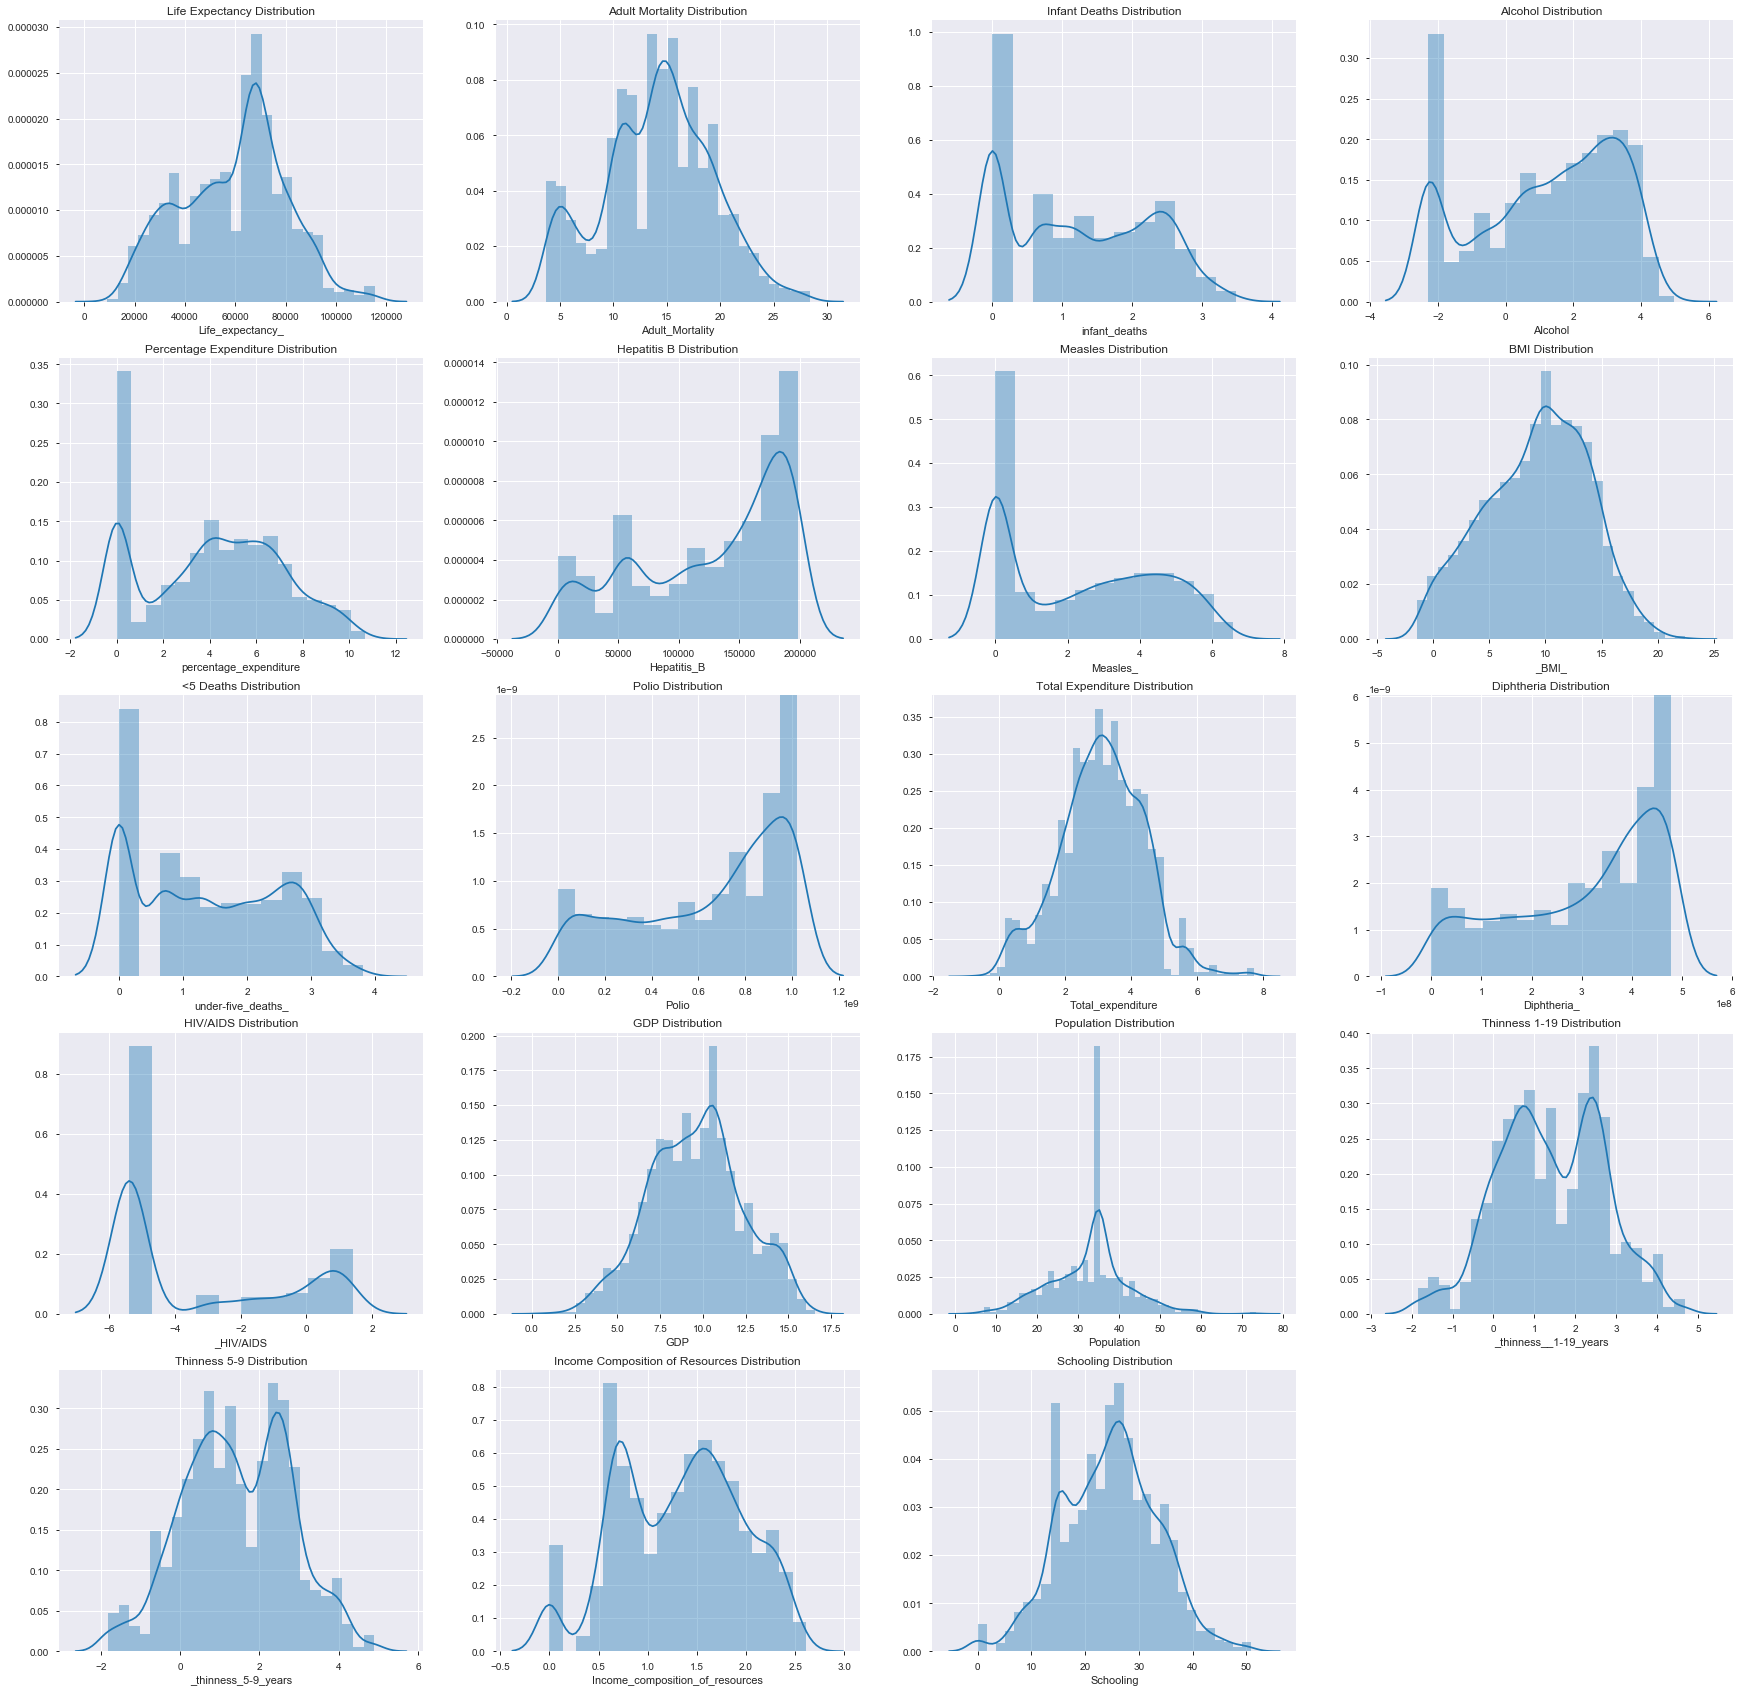

In [46]:
plt.figure(figsize = (30,30))

plt.subplot(5,4,1)
sns.distplot(lifeexpectancy_df_prep.iloc[:,3])
plt.title('Life Expectancy Distribution')
plt.subplot(5,4,2)
sns.distplot(lifeexpectancy_df_prep.iloc[:,4])
plt.title('Adult Mortality Distribution')
plt.subplot(5,4,3)
sns.distplot(lifeexpectancy_df_prep.iloc[:,5])
plt.title('Infant Deaths Distribution')
plt.subplot(5,4,4)
sns.distplot(lifeexpectancy_df_prep.iloc[:,6])
plt.title('Alcohol Distribution')
plt.subplot(5,4,5)
sns.distplot(lifeexpectancy_df_prep.iloc[:,7])
plt.title('Percentage Expenditure Distribution')
plt.subplot(5,4,6)
sns.distplot(lifeexpectancy_df_prep.iloc[:,8])
plt.title('Hepatitis B Distribution')
plt.subplot(5,4,7)
sns.distplot(lifeexpectancy_df_prep.iloc[:,9])
plt.title('Measles Distribution')
plt.subplot(5,4,8)
sns.distplot(lifeexpectancy_df_prep.iloc[:,10])
plt.title('BMI Distribution')
plt.subplot(5,4,9)
sns.distplot(lifeexpectancy_df_prep.iloc[:,11])
plt.title('<5 Deaths Distribution')
plt.subplot(5,4,10)
sns.distplot(lifeexpectancy_df_prep.iloc[:,12])
plt.title('Polio Distribution')
plt.subplot(5,4,11)
sns.distplot(lifeexpectancy_df_prep.iloc[:,13])
plt.title('Total Expenditure Distribution')
plt.subplot(5,4,12)
sns.distplot(lifeexpectancy_df_prep.iloc[:,14])
plt.title('Diphtheria Distribution')
plt.subplot(5,4,13)
sns.distplot(lifeexpectancy_df_prep.iloc[:,15])
plt.title('HIV/AIDS Distribution')
plt.subplot(5,4,14)
sns.distplot(lifeexpectancy_df_prep.iloc[:,16])
plt.title('GDP Distribution')
plt.subplot(5,4,15)
sns.distplot(lifeexpectancy_df_prep.iloc[:,17])
plt.title('Population Distribution')
plt.subplot(5,4,16)
sns.distplot(lifeexpectancy_df_prep.iloc[:,18])
plt.title('Thinness 1-19 Distribution')
plt.subplot(5,4,17)
sns.distplot(lifeexpectancy_df_prep.iloc[:,19])
plt.title('Thinness 5-9 Distribution')
plt.subplot(5,4,18)
sns.distplot(lifeexpectancy_df_prep.iloc[:,20])
plt.title('Income Composition of Resources Distribution')
plt.subplot(5,4,19)
sns.distplot(lifeexpectancy_df_prep.iloc[:,21])
plt.title('Schooling Distribution')

plt.show()

Descriptive stats are displayed above for the transformed variables. The variance and standard deviations for some of the variables is quite high, some even having standard deviations larger than their mean. The distributions for each are also displayed as histograms, many of them being quite close to normal. It is important not to forget the information that can be found in the categorical variables. Below is the analysis of the variables when broken down by status.

In [47]:
lifeexpectancy_df_prep.groupby("Status").mean()

Year  Life_expectancy_  Adult_Mortality  infant_deaths  \
Status                                                                      
Developed   2007.500000      83431.431872         10.82598       0.382542   
Developing  2007.522671      54178.398313         14.77804       1.420787   

             Alcohol  percentage_expenditure    Hepatitis_B  Measles_  \
Status                                                                  
Developed   3.311187                6.165012  126754.694683  2.179558   
Developing  0.759965                3.757421  125286.323450  2.438135   

                _BMI_  under-five_deaths_         Polio  Total_expenditure  \
Status                                                                       
Developed   12.520723            0.447827  8.432835e+08           3.849123   
Developing   8.521907            1.575258  6.032475e+08           2.956968   

             Diphtheria_  _HIV/AIDS        GDP  Population  \
Status                                                       
Developed   4.004114e+08  -5.387825  11.982872   31.856237   
Developing  2.827530e+08  -2.889050   9.113312   32.834550   

            _thinness__1-19_years  _thinness_5-9_years  \
Status                                                   
Developed                0.143714             0.093081   
Developing               1.691045             1.726732   

            Income_composition_of_resources  Schooling  
Status                                                  
Developed                          2.017174  33.775008  
Developing                         1.187899  22.590577

## Feature Engineering

As seen above, there are significant differences between developed nations and developing. Therefore, it is important to transform the status category into something that could be used in a model.

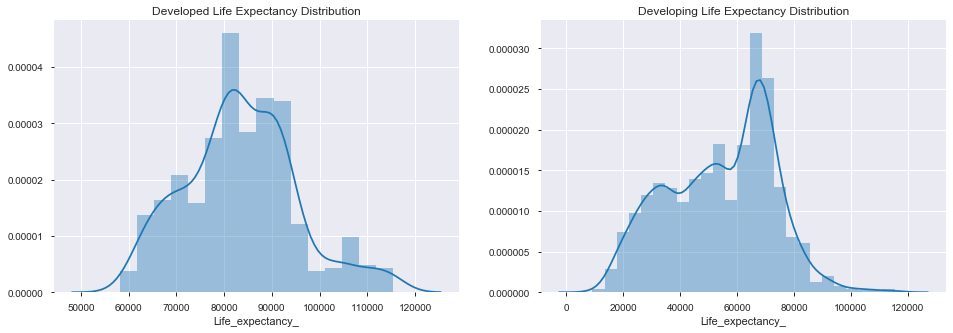

Status
Developed     83431.431872
Developing    54178.398313
Name: Life_expectancy_, dtype: float64

In [50]:
plt.figure(figsize = (16,5))

plt.subplot(1,2,1)
sns.distplot(lifeexpectancy_df_prep[lifeexpectancy_df_prep['Status'] == 'Developed']['Life_expectancy_'])
plt.title('Developed Life Expectancy Distribution')
plt.subplot(1,2,2)
sns.distplot(lifeexpectancy_df_prep[lifeexpectancy_df_prep['Status'] == 'Developing']['Life_expectancy_'])
plt.title('Developing Life Expectancy Distribution')

plt.show()

lifeexpectancy_df_prep.groupby('Status')['Life_expectancy_'].mean()

In [51]:
stats.ttest_ind(lifeexpectancy_df_prep[lifeexpectancy_df_prep['Status'] == 'Developed']['Life_expectancy_'],lifeexpectancy_df_prep[lifeexpectancy_df_prep['Status'] == 'Developing']['Life_expectancy_'])

Ttest_indResult(statistic=34.143980681871845, pvalue=1.8130018281556954e-215)

Here I tested to see if the developed and developing country's life expectancies were we significantly different. With an extreme p-value, this proves that they are and so dummy variables will be used to convert them into a numerical variable below. 

In [52]:
dev = pd.get_dummies(lifeexpectancy_df_prep['Status'],drop_first=True)
dev_df = pd.DataFrame(dev, columns = ['Developing'])
lifeexpectancy_df_prep = pd.concat([lifeexpectancy_df_prep,dev_df],axis = 1)

In [53]:
lifeexpectancy_df_corr = lifeexpectancy_df_prep.corr()
lifeexpectancy_df_corr

Year  Life_expectancy_  Adult_Mortality  \
Year                             1.000000          0.159824        -0.046393   
Life_expectancy_                 0.159824          1.000000        -0.580747   
Adult_Mortality                 -0.046393         -0.580747         1.000000   
infant_deaths                   -0.050909         -0.594458         0.344825   
Alcohol                         -0.175644          0.396363        -0.169685   
percentage_expenditure          -0.065163          0.407627        -0.242673   
Hepatitis_B                      0.253528          0.295915        -0.171113   
Measles_                        -0.095836         -0.280503         0.147615   
_BMI_                            0.080778          0.453256        -0.307466   
under-five_deaths_              -0.050772         -0.614318         0.359628   
Polio                            0.128142          0.607643        -0.327204   
Total_expenditure                0.077720          0.222948        -0.117049   
Diphtheria_                      0.147583          0.612489        -0.326529   
_HIV/AIDS                       -0.055998         -0.759824         0.496741   
GDP                              0.146816          0.567585        -0.305978   
Population                       0.043611         -0.068978         0.066777   
_thinness__1-19_years           -0.036081         -0.569447         0.321092   
_thinness_5-9_years             -0.036962         -0.577571         0.334012   
Income_composition_of_resources  0.204040          0.770054        -0.430491   
Schooling                        0.190159          0.733559        -0.397885   
Developing                       0.001864         -0.533122         0.292436   

                                 infant_deaths   Alcohol  \
Year                                 -0.050909 -0.175644   
Life_expectancy_                     -0.594458  0.396363   
Adult_Mortality                       0.344825 -0.169685   
infant_deaths                         1.000000 -0.360424   
Alcohol                              -0.360424  1.000000   
percentage_expenditure               -0.348124  0.301096   
Hepatitis_B                          -0.287890  0.066889   
Measles_                              0.577419 -0.190353   
_BMI_                                -0.341731  0.208144   
under-five_deaths_                    0.994588 -0.361780   
Polio                                -0.477791  0.287837   
Total_expenditure                    -0.171013  0.273349   
Diphtheria_                          -0.482652  0.294155   
_HIV/AIDS                             0.482954 -0.188870   
GDP                                  -0.427837  0.319319   
Population                            0.393758 -0.026901   
_thinness__1-19_years                 0.482200 -0.430742   
_thinness_5-9_years                   0.492176 -0.427527   
Income_composition_of_resources      -0.521607  0.402605   
Schooling                            -0.560621  0.446112   
Developing                            0.385601 -0.469091   

                                 percentage_expenditure  Hepatitis_B  \
Year                                          -0.065163     0.253528   
Life_expectancy_                               0.407627     0.295915   
Adult_Mortality                               -0.242673    -0.171113   
infant_deaths                                 -0.348124    -0.287890   
Alcohol                                        0.301096     0.066889   
percentage_expenditure                         1.000000     0.063567   
Hepatitis_B                                    0.063567     1.000000   
Measles_                                      -0.140330    -0.262285   
_BMI_                                          0.186986     0.114797   
under-five_deaths_                            -0.351122    -0.292274   
Polio                                          0.235231     0.664233   
Total_expenditure                              0.078334     0.070327   
Diphtheria_        

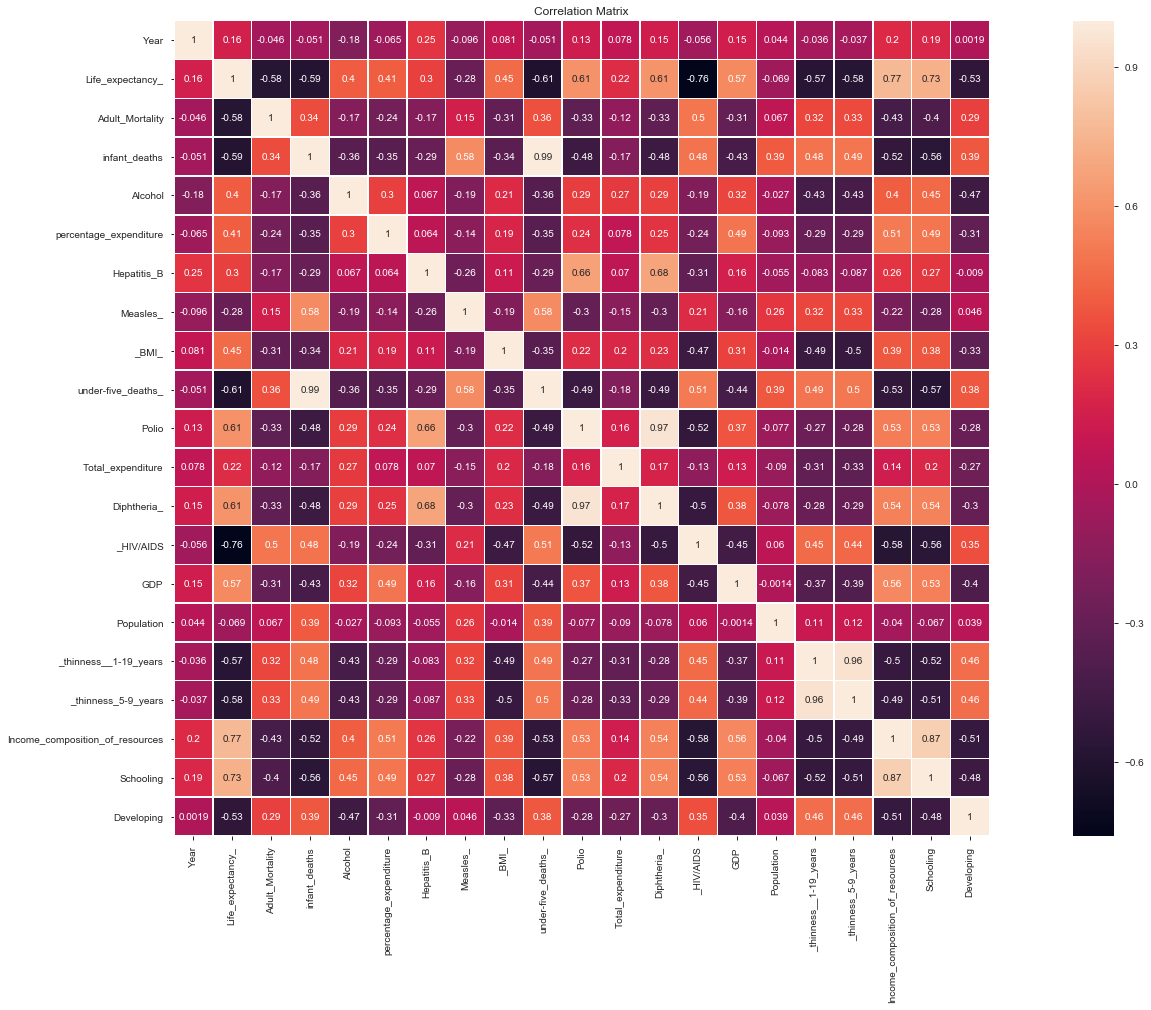

In [54]:
plt.figure(figsize=(30,15))
sns.heatmap(lifeexpectancy_df_corr, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

The correlation factors between each variable were calculated and displayed through this heatmap. Some variables have a high correlation with other variables (>70%). To keep stability, some of the variables need to be dropped. Infant deaths, diphetheria, thinness 1 - 19 years, and schooling are all dropped due to them being highly correlated with other variables. Variables that have 30% correlation or below with life expectancy are also dropped to increase effeciency of the model. This includes year, hepatitis b, measles, total expenditure, and population.

In [55]:
lifeexpectancy_df_prep.head()

Country  Year      Status  Life_expectancy_  Adult_Mortality  \
0  Afghanistan  2015  Developing      47413.943902        18.652305   
1  Afghanistan  2014  Developing      37630.438114        18.891323   
2  Afghanistan  2013  Developing      37630.438114        18.802217   
3  Afghanistan  2012  Developing      36924.047262        18.920887   
4  Afghanistan  2011  Developing      36399.919599        19.009171   

   infant_deaths   Alcohol  percentage_expenditure   Hepatitis_B  Measles_  \
0       2.631244 -2.290646                4.428511  58856.570502  4.839565   
1       2.642828 -2.290646                4.461230  51356.263371  4.440540   
2       2.653978 -2.290646                4.456849  56282.099457  4.373918   
3       2.669952 -2.290646                4.526195  64233.778657  5.213627   
4       2.680137 -2.290646                2.126425  67038.574330  5.244933   

       _BMI_  under-five_deaths_         Polio  Total_expenditure  \
0   9.462290            2.870100  8.971237e+07           4.241374   
1   9.654313            2.883731  7.608825e+07           4.250126   
2   9.844903            2.896804  1.052062e+08           4.228230   
3  10.034109            2.913435  1.533539e+08           4.397648   
4  10.184598            2.929230  1.647994e+08           4.113504   

    Diphtheria_  _HIV/AIDS       GDP  Population  _thinness__1-19_years  \
0  6.657262e+07  -5.387825  7.662392   47.547330               3.803987   
1  5.335137e+07  -5.387825  7.730509   25.966499               3.834171   
2  6.190814e+07  -5.387825  7.774488   47.190586               3.854063   
3  7.672924e+07  -5.387825  7.859064   35.982565               3.873775   
4  8.224445e+07  -5.387825  4.676913   34.985939               3.903013   

   _thinness_5-9_years  Income_composition_of_resources  Schooling  Developing  
0             3.918998                         0.829822  19.639110           1  
1             3.940095                         0.821994  19.384911           1  
2             3.961002                         0.806456  19.131607           1  
3             3.992017                         0.788525  18.879204           1  
4             4.012468                         0.765777  18.127452           1

Using the Box-Cox transformation, the distributions were transformed to become more normal.

In [58]:
LifeE_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,3]).reshape(1,-1)).reshape(-1,1)
AdultM_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,4]).reshape(1,-1)).reshape(-1,1)
Alcohol_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,6]).reshape(1,-1)).reshape(-1,1)
BMI_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,10]).reshape(1,-1)).reshape(-1,1)
Under5_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,11]).reshape(1,-1)).reshape(-1,1)
Polio_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,12]).reshape(1,-1)).reshape(-1,1)
HIVAIDS_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,15]).reshape(1,-1)).reshape(-1,1)
GDP_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,16]).reshape(1,-1)).reshape(-1,1)
Thin59_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,19]).reshape(1,-1)).reshape(-1,1)
IncomeComp_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,20]).reshape(1,-1)).reshape(-1,1)
Dev_NS = normalize(np.array(lifeexpectancy_df_prep.iloc[:,22]).reshape(1,-1)).reshape(-1,1)

LifeE_NS = scale(LifeE_NS).flatten()
AdultM_NS = scale(AdultM_NS).flatten()
Alcohol_NS = scale(Alcohol_NS).flatten()
BMI_NS = scale(BMI_NS).flatten()
Under5_NS = scale(Under5_NS).flatten()
Polio_NS = scale(Polio_NS).flatten()
HIVAIDS_NS = scale(HIVAIDS_NS).flatten()
GDP_NS = scale(GDP_NS).flatten()
Thin59_NS = scale(Thin59_NS).flatten()
IncomeComp_NS = scale(IncomeComp_NS).flatten()
Dev_NS = scale(Dev_NS).flatten()

The data has now been normalized and scaled. This prepares it to go through the Principle Components Analysis process. This will reduce the amount of variables even further into components that represent most of the information from the original 15 variables.

## PCA

In [59]:
df_list = [(LifeE_NS),AdultM_NS,Alcohol_NS,BMI_NS,Under5_NS,Polio_NS,HIVAIDS_NS,GDP_NS,Thin59_NS,IncomeComp_NS,Dev_NS ]
columns_list = ['Life Exp','Adult Mor','Alcohol','BMI','Under5','Polio','HIVAIDS','GDP','Thin 5-9','Income Comp','Developing']
lifeexpectancy_df_ns = pd.DataFrame(df_list, index = columns_list)
lifeexpectancy_df_ns = lifeexpectancy_df_ns.T

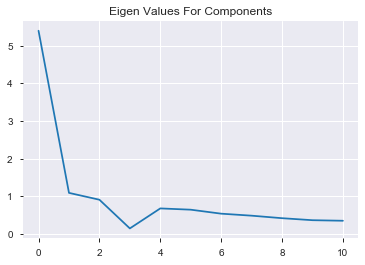

[5.4006516  1.08906244 0.906857   0.1439796  0.67596334 0.64203156
 0.53619947 0.48281504 0.41590813 0.36243758 0.34783957]


In [60]:
X = StandardScaler().fit_transform(lifeexpectancy_df_ns)
Xt = X.T
Cx = np.cov(Xt)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.title('Eigen Values For Components')
plt.show()

print(eig_val_cov)

To inspect how many components to keep, the eigen values are displayed. The first two will be the components used since they have a value over one.

In [61]:
sklearn_pca = PCA(n_components=2)
pca_array = sklearn_pca.fit_transform(X)

In [62]:
sklearn_pca.explained_variance_ratio_

array([0.49080122, 0.09897198])

The first component explains 49% of the variance with the other one only being about 10%. 

In [63]:
pc_1 = []
pc_2 = []

i = 0
while i < len(pca_array):
    pc_1.append(pca_array[i][0])
    i +=1
    
i = 0
while i < len(pca_array):
    pc_2.append(pca_array[i][1])
    i +=1
    

In [64]:
lifeexpectancy_df_ns['Principal Component 1'] = pc_1
lifeexpectancy_df_ns['Principal Component 2'] = pc_2

The components are then added to the the data frame so that it can be used to check its correlation with every other variable/component.

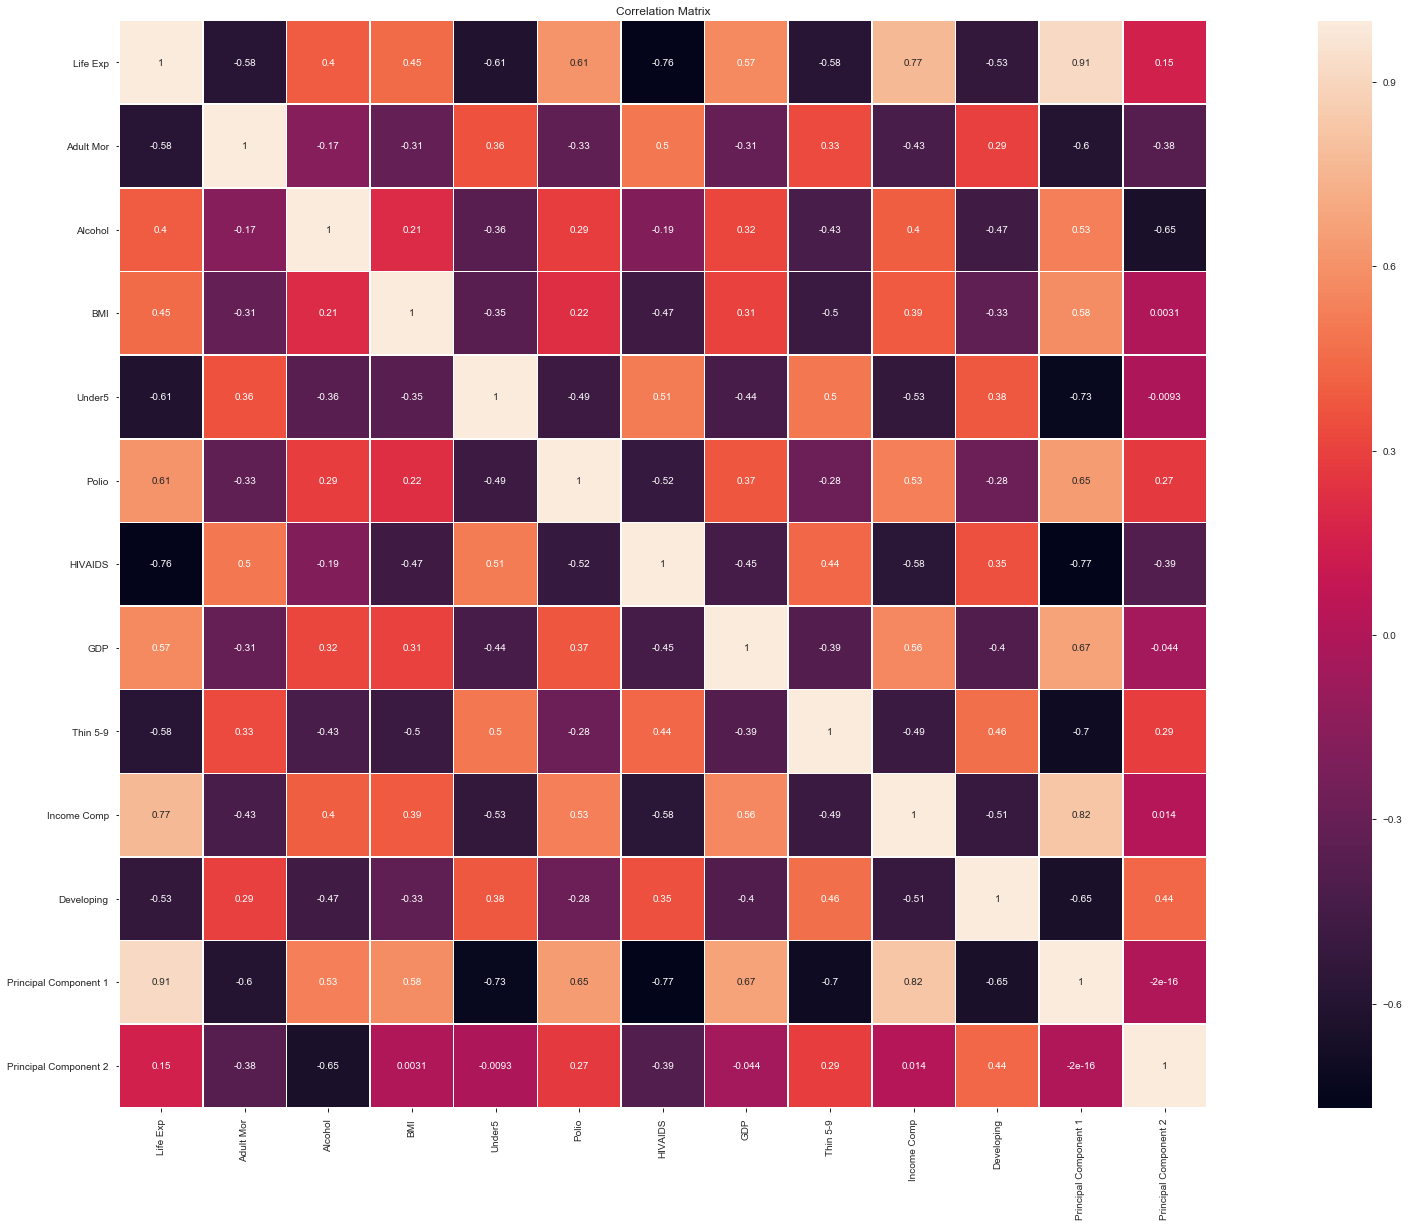

In [65]:
plt.figure(figsize=(40,20))
sns.heatmap(lifeexpectancy_df_ns.corr(), square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [85]:
corr_list_index = list(lifeexpectancy_df_ns.corr().iloc[1:,0].abs().sort_values(ascending = False).index)
corr_list_val = list(lifeexpectancy_df_ns.corr().iloc[1:,0].abs().sort_values(ascending = False))

In [84]:
lifeexpectancy_df_ns.corr().iloc[1:,0].abs().sort_values(ascending = False)

Principal Component 1    0.912763
Income Comp              0.770054
HIVAIDS                  0.759824
Under5                   0.614318
Polio                    0.607643
Adult Mor                0.580747
Thin 5-9                 0.577571
GDP                      0.567585
Developing               0.533122
BMI                      0.453256
Alcohol                  0.396363
Principal Component 2    0.153201
Name: Life Exp, dtype: float64

## Summary

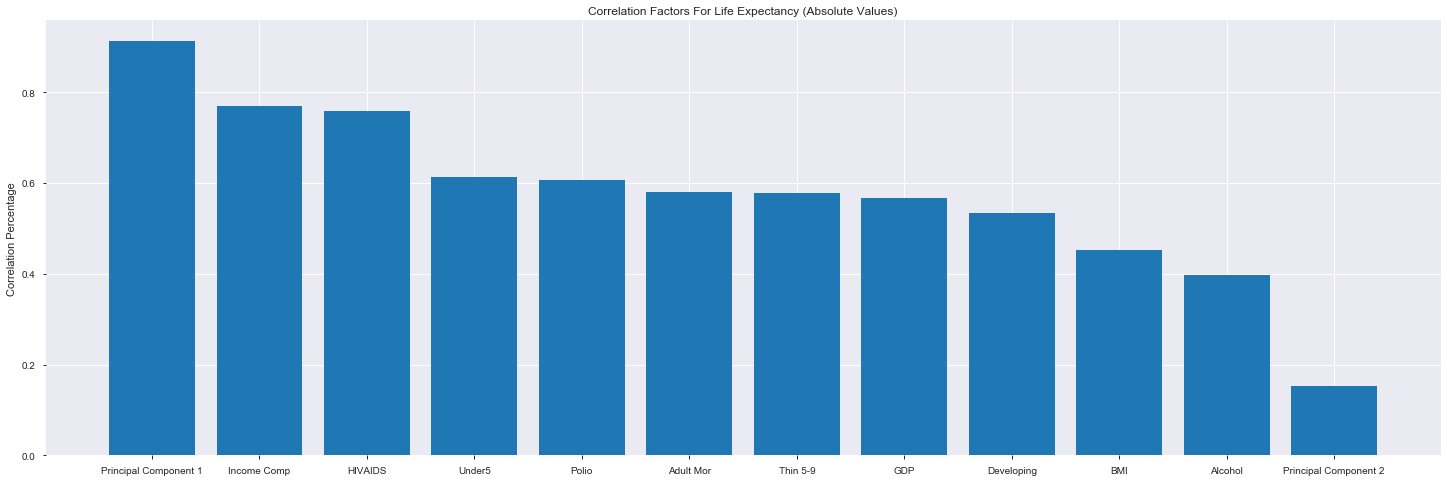

In [87]:
plt.figure(figsize = (25,8))
plt.bar(x = corr_list_index ,height = corr_list_val)
plt.title('Correlation Factors For Life Expectancy (Absolute Values)')
plt.ylabel('Correlation Percentage')
plt.show()

The graph above shows the correlation factors after PCA. As you can see, the first principal component has the highest correlation with life expectancy (91%). The other component did not perform as well as the first one, having a correlation to life expectancy of 15%. Depending on the model, the number of components and variables to use may vary. No matter the number of inputs for the model, the most important feature is the first principal component created. Discarding under 5 deaths, HIV/AIDS, thinness 5-9 years, and income composition of resources could be done to reduce the number of features even further since they are highly correlated (>70%) with PC1.